In [7]:
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm


In [81]:
def plot_map(in_filename, color_mode='screen',
             out_filename='flights_map_mpl.png', absolute=False):
    """Plots the given CSV data files use matplotlib basemap and saves it to
    a PNG file.
    Args:
        in_filename: Filename of the CSV containing the data points.
        out_filename: Output image filename
        color_mode: Use 'screen' if you intend to use the visualisation for
                    on screen display. Use 'print' to save the visualisation
                    with printer-friendly colors.
        absolute: set to True if you want coloring to depend on your dataset
                  parameter value (ie for comparison).
                  When set to false, each coordinate pair gets a different
                  color.
    """

    if color_mode == 'screen':
        bg_color = (0.0, 0.0, 0, 1.0)
        coast_color = (204/255.0, 0, 153/255.0, 0.7)
        color_list = [(0.0, 0.0, 0.0, 0.0),
                      (204/255.0, 0, 153/255.0, 0.6),
                      (255/255.0, 204/255.0, 230/255.0, 1.0)]
    else:
        bg_color = (1.0, 1.0, 1.0, 1.0)
        coast_color = (10.0/255.0, 10.0/255.0, 10/255.0, 0.8)
        color_list = [(1.0, 1.0, 1.0, 0.0),
                      (255/255.0, 204/255.0, 230/255.0, 1.0),
                      (204/255.0, 0, 153/255.0, 0.6)
                      ]

    # define the expected CSV columns
    CSV_COLS = ('dep_lat', 'dep_lon', 'arr_lat', 'arr_lon',
                'nb_flights', 'CO2')

    routes = pd.read_csv(in_filename, names=CSV_COLS, na_values=['\\N'],sep=';',skiprows=1)

    num_routes = len(routes.index)

    # normalize the dataset for color scale
    norm = PowerNorm(0.3, routes['nb_flights'].min(),
                     routes['nb_flights'].max())
    # norm = Normalize(routes['nb_flights'].min(), routes['nb_flights'].max())

    # create a linear color scale with enough colors
    if absolute:
        n = routes['nb_flights'].max()
    else:
        n = num_routes
    cmap = LinearSegmentedColormap.from_list('cmap_flights', color_list,
                                             N=n)
    # create the map and draw country boundaries
    plt.figure(figsize=(27, 20))
    lowerlat=32
    lowerlon=-27
    upperlat=65
    upperlon=33
    map = Basemap(llcrnrlon=lowerlon,llcrnrlat=lowerlat,urcrnrlon=upperlon,urcrnrlat=upperlat, resolution='i', 
                projection='merc', lat_0=0, lon_0=0)
    map.bluemarble()
    map.drawcoastlines()
    map.drawcountries()
#     map.drawmapscale(lowerlon+12, lowerlat+2, -3, 45, 2000, barstyle='fancy')

    # create the points on the map
#     IATA = [LHR,CDG,AMS,FRA,MAD,BCN,MUC,FCO,DUB,ARN,LIS,TXL,HEL,WAW,EDI,OTP,HER,KEF,PMO,FNC]
    lats = [51.4706,52.3086,50.0333,40.4719,41.2971,48.3538,41.8003,53.4213,
           59.6519,38.7813,52.5597,60.3172,52.1657,55.95,44.5711,35.3397,63.985,
           38.1108,32.6979]
    lons = [-0.46194,4.7639,8.5706,-3.5626,2.0785,11.7861,12.2389,-6.2701,17.9186,
           -9.1359,13.2877,24.9633,20.9671,-3.3725,26.085,25.1803,-22.6056,13.3133,
           -16.7745]
    x, y = map(lons, lats)
    map.scatter(x, y,color='blue',label='Airports')
    lat_hub = 49.0128
    lon_hub = 2.55
    x1, y1 = map(lon_hub, lat_hub)
    map.scatter(x1, y1, s=200,color='blue',label='Hub')
    
    
    IATA = ['LHR','AMS','FRA','MAD','BCN','MUC','FCO','DUB','ARN','LIS','TXL','HEL',
            'WAW','EDI','OTP','HER','KEF','PMO','FNC']
    for k, code in enumerate(IATA):
        plt.text(x[k], y[k], code, fontsize=10,fontweight='bold',va='bottom',color='red',label=str(code))
    plt.text(x1, y1, 'CDG',fontsize=14,fontweight='bold',va='bottom',color='red',label='Hub')
#              ha='left',va='bottom',color='k')
#              ha='left',va='bottom',color='k')
#         lon = -0.46194
#         lat = 51.4706
#         x, y = map(lon, lat)
#         plt.text(x, y, 'LHR',fontsize=12,fontweight='bold',
#              ha='left',va='bottom',color='k')
    
    linestyles=['-', '--', '-.', ':']
    colours=['y', 'r', 'g', 'w']
    # plot each route with its color depending on the number of flights
    for i, route in enumerate(routes.sort_values(by='nb_flights',
                              ascending=True).iterrows()):
        route = route[1]
#         if absolute:
#             color = cmap(norm(int(route['CO2'])))
#         else:
#             color = cmap(i * 1.0 / num_routes)
        line, = map.drawgreatcircle(route['dep_lon'], route['dep_lat'],
                                  route['arr_lon'], route['arr_lat'],
                                  linewidth=10,linestyle=linestyles[int(route['nb_flights'])],
                                    color=colours[int(route['nb_flights'])])
#         print(route['nb_flights'])
        # if the path wraps the image, basemap plots a nasty line connecting
        # the points at the opposite border of the map.
        # we thus detect path that are bigger than 30km and split them
        # by adding a NaN
        path = line.get_path()
        cut_point, = np.where(np.abs(np.diff(path.vertices[:, 0])) > 30000e3)
        if len(cut_point) > 0:
            cut_point = cut_point[0]
            vertices = np.concatenate([path.vertices[:cut_point, :],
                                      [[np.nan, np.nan]],
                                      path.vertices[cut_point+1:, :]])
            path.codes = None  # treat vertices as a serie of line segments
            path.vertices = vertices
    plt.legend(loc='lower left')
    # save the map
    plt.savefig(out_filename, format='png', bbox_inches='tight')

ValueError: cannot convert float NaN to integer

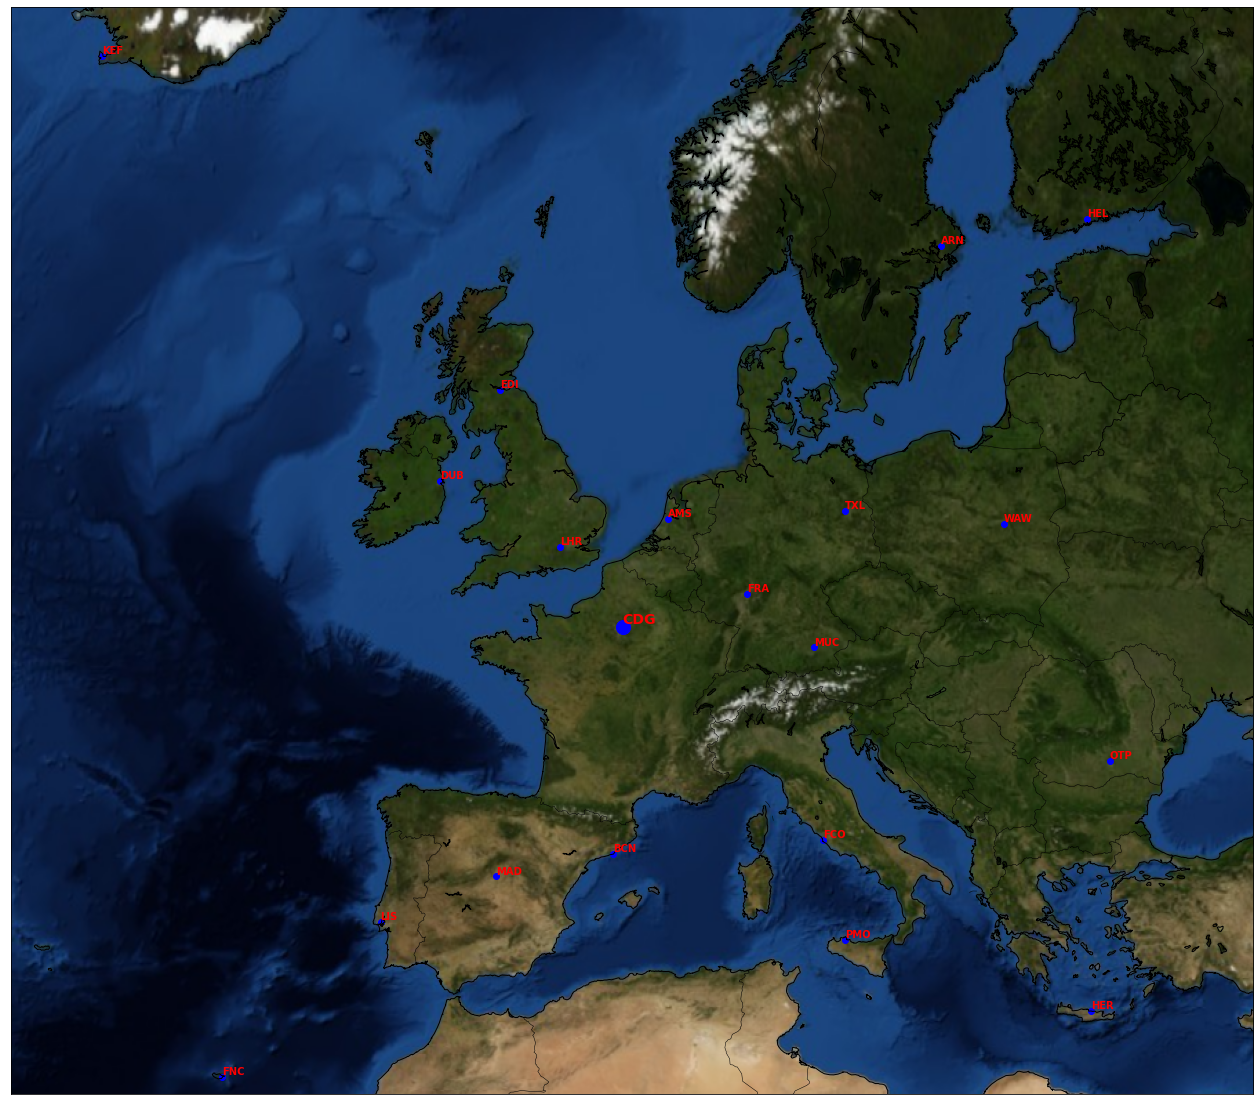

In [82]:
if __name__ == '__main__':
    # use 'screen' color mode for on-screen display. Use 'print' if you intend
    # to print the map
    plot_map('data.csv')